In [45]:
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as pil
import sys
sys.path.append('../pba-signet/')

import pba.augmentation_transforms_hp as augmentation_transforms_hp
from pba.utils import parse_log_schedule
from pba.data_utils import parse_policy


In [46]:
# Initialize hp policies.
hp_epochs = 35
train_epochs = 35
multiplier=float(train_epochs)/ hp_epochs
save=True

search_name = 'search_train_5k_t8_mono2_15aug_X_newprob'
policy_file = 'pbt_policy_00002.txt'

# set accordingly the operations in augmentaion_transforms_hp.py

In [47]:
policy_path = '../results/'+ search_name +'/' + policy_file
hp_policy = (parse_log_schedule(policy_path, hp_epochs, multiplier), 'hp_policy')
policy, dset = hp_policy

save_path = 'images/' + search_name
if not os.path.exists(save_path):
    os.makedirs(save_path)

def parse_policy_hyperparams(policy_hyperparams):
    """We have two sets of hparams for each operation, which we need to split up."""
    split = len(policy_hyperparams) // 2
    policy = parse_policy(policy_hyperparams[:split], augmentation_transforms_hp)
    
    policy.extend(parse_policy(policy_hyperparams[split:], augmentation_transforms_hp))
    return policy

INFO:tensorflow:final len 35


In [61]:
root = "/media/ehdd_2t/amanraj/data/struct2depth/kitti_processed/2011_09_26_drive_0009_sync_03//"
image_path = root + "/0000000030.png"


#root = "/media/ehdd_2t/amanraj/data/struct2depth/kitti_processed/2011_09_26_drive_0015_sync_02"
#image_path = root + "/0000000099.png"

input_height = 128
input_width = 416

def read_image_data_for_input(img_path):
    """
    Read image sequence and split frames, normalize to range [0, 1]
    :param img_path: path of image sequence
    :return: tgt_img, src_img_1, srcm_2
    """
    # read image
    fh = open(img_path, 'rb')
    image_seq = np.array(pil.open(fh), dtype='float32')

    # get height and width of frame, total 3 frames ins sequence
    height, width, _ = image_seq.shape
    width = width // 3
        
    src_img_1 = image_seq[:, :width, :]
    tgt_img = image_seq[:, width:2*width, :]
    src_img_2 = image_seq[:, 2*width:, :]
    
    if input_width != width or input_height != height:
        # resize to input height and width
        src_img_1 = cv2.resize(src_img_1, (input_width, input_height), interpolation=cv2.INTER_LINEAR)
        tgt_img = cv2.resize(tgt_img, (input_width, input_height), interpolation=cv2.INTER_LINEAR)
        src_img_2 = cv2.resize(src_img_2, (input_width, input_height), interpolation=cv2.INTER_LINEAR)

    # Normalize
    tgt_img = tgt_img.astype('float32') / 255.0
    src_img_1 = src_img_1.astype('float32') / 255.0
    src_img_2 = src_img_2.astype('float32') / 255.0

    return tgt_img, src_img_1, src_img_2


image_size = (input_height, input_width)

# Number of images to display
num_images = 10

epoch = 30

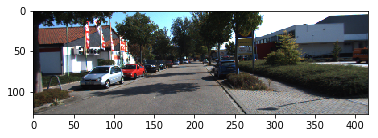

Showing 10 example images at epoch 30.

Applied augmentations:
INFO:tensorflow:Op: Sharpness, Magnitude: 5, Prob: 0.7
INFO:tensorflow:Op: SpeedBlur, Magnitude: 8, Prob: 0.4
images/search_train_5k_t8_mono2_15aug_X_newprob/image_0.png


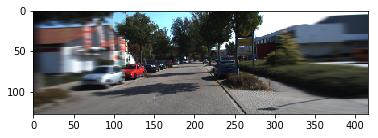

Applied augmentations:
INFO:tensorflow:Op: Posterize, Magnitude: 3, Prob: 0.7
INFO:tensorflow:Op: Solarize, Magnitude: 0, Prob: 1.0
images/search_train_5k_t8_mono2_15aug_X_newprob/image_1.png


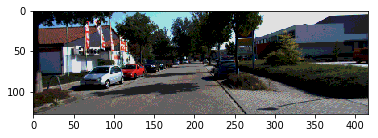

Applied augmentations:
INFO:tensorflow:Op: Smooth, Magnitude: 9, Prob: 1.0
INFO:tensorflow:Op: Fog, Magnitude: 8, Prob: 0.7
images/search_train_5k_t8_mono2_15aug_X_newprob/image_2.png


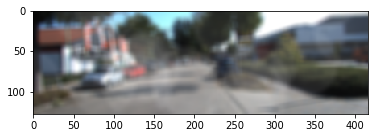

Applied augmentations:
INFO:tensorflow:Op: AutoContrast, Magnitude: 9, Prob: 0.7
INFO:tensorflow:Op: Color, Magnitude: 2, Prob: 0.6
INFO:tensorflow:Op: Cutout, Magnitude: 7, Prob: 0.1
images/search_train_5k_t8_mono2_15aug_X_newprob/image_3.png


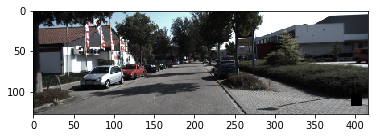

Applied augmentations:
images/search_train_5k_t8_mono2_15aug_X_newprob/image_4.png


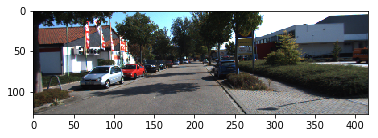

Applied augmentations:
INFO:tensorflow:Op: Solarize, Magnitude: 0, Prob: 1.0
INFO:tensorflow:Op: FlipLR, Magnitude: 7, Prob: 0.2
images/search_train_5k_t8_mono2_15aug_X_newprob/image_5.png


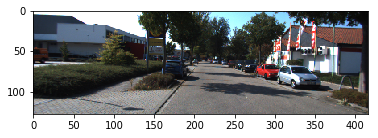

Applied augmentations:
INFO:tensorflow:Op: Smooth, Magnitude: 9, Prob: 1.0
INFO:tensorflow:Op: AutoContrast, Magnitude: 9, Prob: 0.7
images/search_train_5k_t8_mono2_15aug_X_newprob/image_6.png


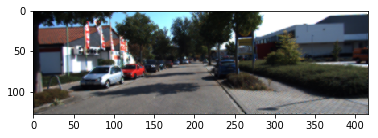

Applied augmentations:
INFO:tensorflow:Op: Cutout, Magnitude: 9, Prob: 0.3
INFO:tensorflow:Op: Snow, Magnitude: 2, Prob: 0.5
images/search_train_5k_t8_mono2_15aug_X_newprob/image_7.png


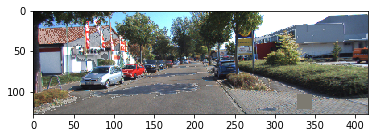

Applied augmentations:
INFO:tensorflow:Op: Snow, Magnitude: 2, Prob: 0.5
images/search_train_5k_t8_mono2_15aug_X_newprob/image_8.png


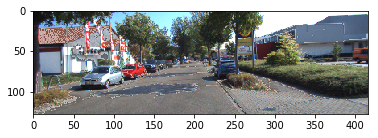

Applied augmentations:
images/search_train_5k_t8_mono2_15aug_X_newprob/image_9.png


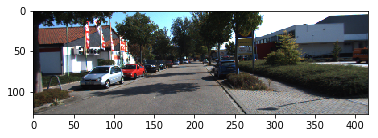

In [67]:
# Load image and Normalize
tgt_img, src_img_1, src_img_2 = read_image_data_for_input(image_path)

data = {'img_data': [tgt_img, src_img_1, src_img_2], 'intrinsic': np.random.rand(3, 3)}

plt.imshow(tgt_img)
plt.imsave(save_path+"/original.png", tgt_img)
plt.show()
print('Showing 10 example images at epoch {}.\n'.format(epoch))

for idx in range(num_images):
    # Apply augmentations
    print('Applied augmentations:')
    data_aug = augmentation_transforms_hp.apply_policy(
        policy=parse_policy_hyperparams(policy[epoch - 1]),
        data=copy.copy(data),
        image_size=image_size,
        verbose=True)
    
    tgt_img_aug,_,_ = data_aug['img_data']
    plt.imshow(tgt_img_aug)
    img_name = save_path+"/image_{}.png".format(idx)
    plt.imsave(img_name, tgt_img_aug)
    print(img_name)
    plt.show()